In [1]:
import sys, yaml, os
sys.path.append('../')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utils import visualize
from forward_model import Surrogate
import argparse

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Train from scratch or load pretrained model

In [2]:
args = argparse.ArgumentParser().parse_args('')
config = '../config/case1b.yaml'

with open(config, 'r') as f:
    config = yaml.safe_load(f)
    for key, value in config.items():
        setattr(args, key, value)

### Train from scratch
# trainer = Surrogate(args)
# trainer.train()

### Or load a pre-trained model
project_dir = '../weights/case1b'
model_dir = os.path.join(project_dir, 'best_train_loss_model.pt')

setattr(args, 'eval_type', 'forward_eval')
setattr(args, 'project_dir', project_dir)

trainer = Surrogate(args)
trainer.load_weights(weight_path=model_dir)
trainer.create_eval_dir()



The model is set to be:  ParametricDeepONet
The decoder mode is:  nonlinear
The depth of the model is:  3
The width of the model is:  300
Seed is randomly set to be:  4845


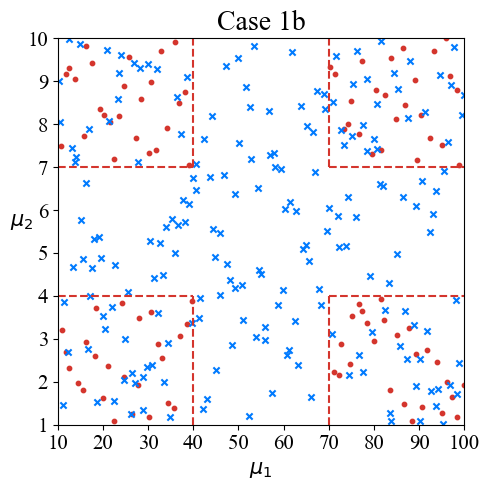

In [3]:
visualize.plot_params_range(trainer.train_data, trainer.test_data, sub_case='case1b', save_as = None)

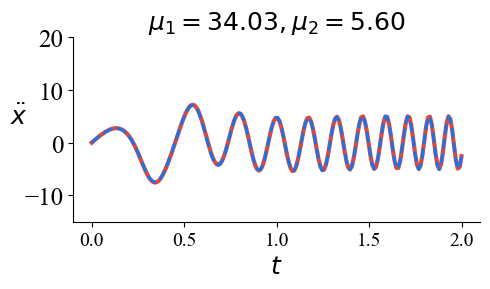

<Figure size 600x50 with 0 Axes>

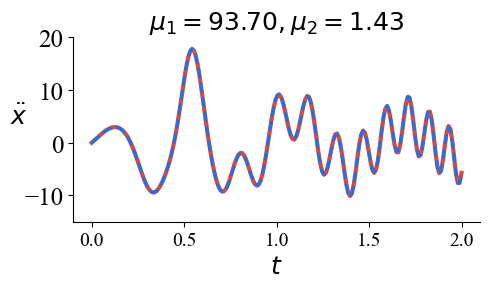

<Figure size 600x50 with 0 Axes>

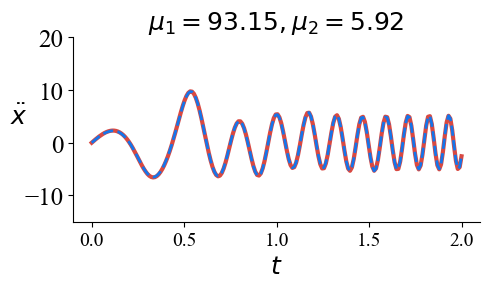

<Figure size 600x50 with 0 Axes>

In [4]:
test_x, test_params, test_y, test_ts = trainer.test_data
test_data_pred = trainer.evaluate_y()
# idd: ood: 8
random_idx_list = np.random.randint(0, 200, 3)
for idx in random_idx_list:
    visualize.plot_case1_data_samples(
        test_data_pred[idx],
        test_y[idx],
        para=test_params[idx],
        ts=test_ts[idx],
        save_as=os.path.join(
            trainer.save_dir, "sample_{}_mu1-{:.2f}_mu2-{:.2f}.png".format(idx, test_params[idx][0], test_params[idx][1])
        ),
    )

In [5]:
k = np.linspace(10, 100, 200)
c = np.linspace(1, 10, 200)

f = test_x[0]
f = f.repeat(100, 1)

class LatentNet(nn.Module):
    def __init__(self, model_type=''):
        super(LatentNet, self).__init__()
        self.model_type = model_type
        if model_type == 'ParametricDeepONet':
            self.net = trainer.model.params_net
            
    def forward(self, x_t, mu, y_coord):
        if self.model_type == 'ParametricDeepONet':
            return self.net(mu)
            
latent_net = LatentNet(model_type='ParametricDeepONet')
X, Y, Z, Z_train, Z_test = trainer.generate_meshgrid(k, c, latent_net = latent_net, model_type = 'ParametricDeepONet')

(40000, 2)
The shape of mesh_params_latent is:  torch.Size([40000, 300])
The shape of latent is:  torch.Size([40100, 300])
(200, 200)


/tmp/ipykernel_6849/2092031280.py:15: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(tickfz)


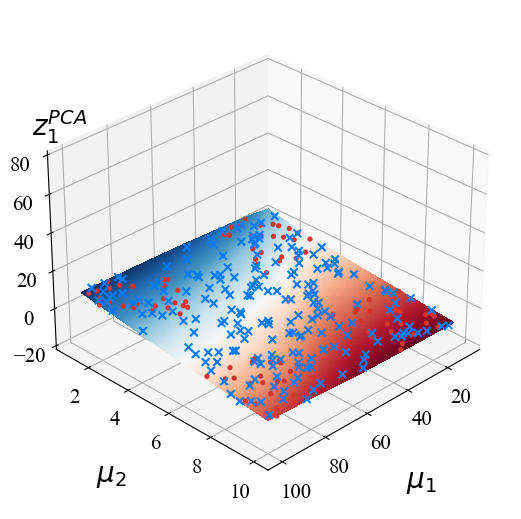

In [6]:
from pylab import cm
fig = plt.figure(figsize=(5, 5))
fz = 20
tickfz = 15
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
ax.plot_surface(X, Y, Z, cmap = 'RdBu', zorder = 1, rstride=1, cstride=1,linewidth=0, antialiased=False, alpha=1)
ax.scatter(trainer.train_data[1][:,0].cpu().detach().numpy(), trainer.train_data[1][:,1].cpu().detach().numpy(), 
           Z_train[:],color = '#D4352D', s = 30, label = 'Training data', marker= '.' , alpha = 1, zorder = 4)
ax.scatter(trainer.test_data[1][:,0].cpu().detach().numpy(), trainer.test_data[1][:,1].cpu().detach().numpy(), 
           Z_test[:], s = 30, label = 'Test data', marker= 'x', facecolors = '#007afe', alpha = 1, zorder = 10)
ax.view_init(30, 45)

plt.xticks(fontsize = tickfz)
plt.yticks(fontsize = tickfz)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(tickfz)
ax.set_zticks(np.arange(-20, 81, 20))

text_coords_mu1 = (100, 16, 0)
text_coords_mu2 = (165, 9, 0)
ax.text(text_coords_mu1[0], text_coords_mu1[1], text_coords_mu1[2], r'$\mu_1$', fontsize = fz, color = 'black', rotation = 0)
ax.text(text_coords_mu2[0], text_coords_mu2[1], text_coords_mu2[2], r'$\mu_2$', fontsize = fz, color = 'black', rotation = 0)
ax.zaxis.set_rotate_label(False)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

ax.set_box_aspect(None, zoom=0.95)
text_coords = (110, 0, 90)
ax.text(text_coords[0], text_coords[1], text_coords[2], r'$z^{PCA}_1$', fontsize = fz, color = 'black')

#ax.grid(False)
plt.savefig('./latent_case1b.png', transparent=True)
plt.show()